<a href="https://colab.research.google.com/github/shreevigneshs/UCSC-243/blob/main/assignments/nlp_243_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from typing import List
import re
import string
import math
import os

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

from tqdm import tqdm
import spacy

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import pickle as pkl
from argparse import Namespace
import matplotlib.ticker as plticker

In [ ]:
# we do minor data cleaning and split the data into train and val splits.

In [6]:
path_to_train_csv = "/content/drive/MyDrive/NLP243/assignments/1_new/hw1_train-1.csv"
path_to_clean_train_csv = "/content/drive/MyDrive/NLP243/assignments/1_new/clean_hw1_train-1.csv"
model_save_directory = '/content/drive/MyDrive/NLP243/assignments/1_new/model/'
path_to_test_movies_csv = '/content/drive/MyDrive/NLP243/assignments/1_new/hw1_test-2.csv'

In [7]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"([.,!?])", r" \1 ", text)
  text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
  return text

df = pd.read_csv(path_to_train_csv)
df["split"] = "train"
df.columns = ["id", "text", "labels", "split"]
df.labels = df.labels.replace(np.nan, "none", regex=True)

np.random.seed(20221002)
train_proportion = 0.80
val_proportion = 0.20

item_list = list(row.to_dict() for _, row in df.iterrows())
np.random.shuffle(item_list)

# Create split data
final_list = []

n_total = len(item_list)
n_train = int(train_proportion * n_total)
n_val = int(val_proportion * n_total)

# Give data point a split attribute
for item in item_list[:n_train]:
  item['split'] = 'train'
    
for item in item_list[n_train:n_train+n_val+1]:
  item['split'] = 'val'

# Add to final list
final_list.extend(item_list)

final_df = pd.DataFrame(final_list)
final_df.text = final_df.text.apply(preprocess_text)
final_df.to_csv(path_to_clean_train_csv)

In [8]:
print(final_df.tail())

        id                                  text  \
2307  1332  find movies produced by disney pixar   
2308  1809   find movies with tom cruise in them   
2309  1945  what pg movies are currently showing   
2310   838                    movies from the us   
2311   407       when did happiness get released   

                                       labels split  
2307               movie.production_companies   val  
2308                     movie.starring.actor   val  
2309  movie.rating movie.initial_release_date   val  
2310                            movie.country   val  
2311               movie.initial_release_date   val  


In [9]:
# define vocabulary, vectorizer, label indexer and dataset

class Vocabulary(object):

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<unk>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)


class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, text_vocab):
       
        self.text_vocab = text_vocab

    def vectorize(self, text):
        """Create a collapsed one-hit vector
        
        Args:
            text (str): text
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.text_vocab), dtype=np.float32)
        
        for token in text.split():
            if token not in string.punctuation:
                
                # use this fot one hot encoding
                one_hot[self.text_vocab.lookup_token(token)] = 1

                # # use this for count vectorizer
                # one_hot[self.text_vocab.lookup_token(token)] += 1

        return one_hot

    @classmethod
    def from_dataframe(cls, df, cutoff=1500):
        text_vocab = Vocabulary(add_unk=True)
        

        # Add top words if count > provided count
        word_counts = Counter()
        for text in df.text:
            for word in text.split():
                if word not in string.punctuation:
                    word_counts[word] += 1
        
        print(len(word_counts.most_common()))

        for word, count in dict(word_counts.most_common(cutoff)).items():
            text_vocab.add_token(word)
        
        return cls(text_vocab)

    @classmethod
    def from_serializable(cls, contents):
        text_vocab = Vocabulary.from_serializable(contents['text_vocab'])

        return cls(text_vocab=text_vocab)

    def to_serializable(self):
        return {'text_vocab': self.text_vocab.to_serializable()}


class LabelIndexer(object):
  # a standart label indexer similar to the vectorizer

    def __init__(self, labels, label2idx=None, idx2label=None):
        
        self.labels = labels
        self.n_labels = len(self.labels)
        self.label2idx = {label: i for i, label in enumerate(self.labels)} if label2idx is None else label2idx
        self.idx2label = {i:label for label, i in self.label2idx.items()} if idx2label is None else idx2label

    def encode(self, y):
        one_hot_encoded = np.zeros(self.n_labels, dtype=int)
        normalized_label = list(set([_split_label for _split_label in y.split()]))
        for _label in normalized_label:
          one_hot_encoded[self.label2idx[_label]] = 1.
        return one_hot_encoded

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])
    
    @classmethod
    def from_dataframe(cls, df):
        labels = list(set([_split_label for label in df.labels.unique().flatten() for _split_label in label.split()]))
        return cls(labels)
    
    @classmethod
    def from_serializable(cls, contents):
        labels = LabelIndexer.from_serializable(contents['labels'])
        label2idx = LabelIndexer.from_serializable(contents['label2idx'])
        idx2label = LabelIndexer.from_serializable(contents['idx2label'])
        
        return cls(labels=labels, label2idx=label2idx, idx2label=idx2label)

    def to_serializable(self):
        return {
            'labels': self.labels.to_serializable(),
            'label2idx': self.label2idx.to_serializable(),
            'idx2label': self.idx2label.to_serializable()
        }
    
    def __str__(self):
        return "<LabelIndexer(size=%d)>" % len(self)

    def __len__(self):
        return self.n_labels


class MovieDataset(Dataset):
    def __init__(self, movie_df, vectorizer, label_indexer, tfidf=False):
        """
        Args:
            movie_df (pandas.DataFrame): the dataset
            vectorizer (Vectorizer): vectorizer instantiated from dataset
        """
        self.movie_df = movie_df
        self._vectorizer = vectorizer
        self._label_indexer = label_indexer

        self.train_df = self.movie_df[self.movie_df.split=='train']
        # self.train_df = self.movie_df
        self.train_size = len(self.train_df)

        self.val_df = self.movie_df[self.movie_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        self.tfidf = tfidf
        if self.tfidf:
            self._vectorizer.fit(list(self.train_df.text))

    @classmethod
    def load_dataset_and_make_vectorizer_and_label_indexer(cls, movie_csv, tfidf=False):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of dataset
        """
        movie_df = pd.read_csv(movie_csv)

        if tfidf:
          tfidf_vectroizer = TfidfVectorizer(ngram_range=(1,2), norm=None, smooth_idf=False, use_idf=True)
          return cls(movie_df, tfidf_vectroizer, LabelIndexer.from_dataframe(movie_df), tfidf=True)
        else:
          return cls(movie_df, Vectorizer.from_dataframe(movie_df), LabelIndexer.from_dataframe(movie_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_label_indexer(self):
        """ returns label indexer """
        return self._label_indexer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train" or "val"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        if self.tfidf:
          text_vector = torch.FloatTensor(self._vectorizer.transform([row.text]).todense()).squeeze(0)

        else:
          text_vector = \
              self._vectorizer.vectorize(row.text)

        label_index = \
            self._label_indexer.encode(row.labels)

        return {'x_data': text_vector,
                'y_target': label_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size


# a function to develop 
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [10]:
# model definition
# we try out both a one-hidden-layer MLP and two-hidden-layer MLP with different parameters for dropout, batch normalization, epochs.
# we also try out ensembling the outputs of two MLP models.
# To run in this setting first train the model 1 and model 2 separately and then combine the outputs.

class MLPMultiLabelClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size, use_hidden2=True, hidden_size2=64, use_dropout=True, dropout_p1=0.2, dropout_p2=0.3, use_batch_norm=True):
        super(MLPMultiLabelClassifier, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p1=dropout_p1
        self.dropout_p2=dropout_p2
        self.use_batch_norm=use_batch_norm

        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.use_hidden2 = use_hidden2
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.fci1 = nn.Linear(in_features=input_size, 
                             out_features=hidden_size1, bias=True)
        self.fc1o = nn.Linear(in_features=hidden_size1, 
                             out_features=output_size, bias=True)
        self.batch_norm1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.fc12 = nn.Linear(in_features=hidden_size1, out_features=hidden_size2, bias=True)
        self.batch_norm2 = nn.BatchNorm1d(num_features=hidden_size2)
        self.fc2o = nn.Linear(in_features=hidden_size2, out_features=output_size, bias=True)
        if self.use_dropout:
          self.dropout1 = nn.Dropout(dropout_p1)
          self.dropout2 = nn.Dropout(dropout_p2)
        else:
          self.dropout1 = nn.Dropout(0.0)
          self.dropout2 = nn.Dropout(0.0)
        self.apply(self._init_weights)
    
    def _init_weights(self, module, input_size=0, output_size=0):
        # for every Linear layer in a model..
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight.data, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x_in):
        if self.use_batch_norm:
            y1_out = F.relu(self.batch_norm1(self.fci1(x_in).squeeze()))
            if self.use_hidden2:
              y2_out = self.fc12(self.dropout1(y1_out)).squeeze()
              y3_out = self.fc2o(self.dropout2(F.relu(self.batch_norm2(y2_out)))).squeeze()
              y_out = y3_out
            else:
              y2_out = self.fc1o(self.dropout1(y1_out)).squeeze()
              y_out = y2_out
        else:
            y1_out = F.relu(self.fci1(x_in).squeeze())
            if self.use_hidden2:
              y2_out = self.fc12(self.dropout1(y1_out)).squeeze()
              y3_out = self.fc2o(self.dropout2(F.relu(y2_out))).squeeze()
              y_out = y3_out
            else:
              y2_out = self.fc1o(self.dropout1(y1_out)).squeeze()
              y_out = y2_out
        return y_out



1132
Train classification report after epoch: 0
                            precision    recall  f1-score   support

      movie.starring.actor       0.70      0.58      0.63       275
movie.initial_release_date       0.80      0.59      0.68       144
       movie.gross_revenue       0.03      0.04      0.03        27
              movie.rating       0.86      0.69      0.76       166
            movie.language       0.71      0.58      0.64       182
               movie.music       0.00      0.00      0.00         3
               movie.genre       0.38      0.23      0.29        98
           movie.locations       0.00      0.00      0.00         3
            movie.subjects       0.49      0.40      0.44        85
      person.date_of_birth       0.00      0.00      0.00         5
movie.production_companies       0.36      0.30      0.33        77
         movie.produced_by       0.77      0.57      0.65       145
         movie.directed_by       0.73      0.66      0.69       265

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 1
                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.88      0.91       275
movie.initial_release_date       0.95      0.87      0.91       145
       movie.gross_revenue       1.00      0.58      0.73        26
              movie.rating       1.00      0.96      0.98       168
            movie.language       0.96      0.90      0.93       182
               movie.music       0.00      0.00      0.00         3
               movie.genre       0.99      0.71      0.83        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.93      0.96        84
      person.date_of_birth       1.00      0.40      0.57         5
movie.production_companies       0.91      0.76      0.83        76
         movie.produced_by       0.94      0.92      0.93       145
         movie.directed_by       0.94      0.91      0.92       266
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Train classification report after epoch: 2
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.95      0.96       274
movie.initial_release_date       1.00      0.97      0.99       145
       movie.gross_revenue       1.00      0.85      0.92        27
              movie.rating       1.00      0.98      0.99       167
            movie.language       1.00      0.96      0.98       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.98      0.89      0.93        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       0.80      0.80      0.80         5
movie.production_companies       0.99      0.94      0.96        77
         movie.produced_by       0.97      0.97      0.97       146
         movie.directed_by       0.97      0.96      0.96       264
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.80      0.87        76
movie.initial_release_date       1.00      0.79      0.88        42
       movie.gross_revenue       1.00      0.83      0.91         6
              movie.rating       1.00      1.00      1.00        39
            movie.language       1.00      0.97      0.99        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.90      0.95        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.83      0.71      0.77        14
         movie.produced_by       0.89      0.89      0.89        28
         movie.directed_by       0.94      0.89      0.92        76
                      none       0.91      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 3
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.97      0.98       276
movie.initial_release_date       0.98      0.97      0.97       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.99      0.99       169
            movie.language       1.00      0.99      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         2
            movie.subjects       1.00      0.99      0.99        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.97      0.97        77
         movie.produced_by       0.97      0.98      0.98       146
         movie.directed_by       0.98      0.99      0.99       265
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 4
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.99      0.99       274
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       0.99      0.99      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.95      0.97        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.98      0.99       146
         movie.directed_by       0.98      0.98      0.98       264
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.83      0.90        76
movie.initial_release_date       0.97      0.88      0.92        40
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       0.98      1.00      0.99        41
            movie.language       0.97      0.97      0.97        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       0.96      0.87      0.92        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.83      1.00      0.91        15
         movie.produced_by       1.00      0.93      0.96        29
         movie.directed_by       0.97      0.88      0.93        78
                      none       0.93      0.86

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 5
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       1.00      0.99      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
            movie.language       0.99      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       0.99      0.98      0.99       146
         movie.directed_by       0.98      0.96      0.97       263
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 6
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.99      0.99       144
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.98      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        76
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       0.98      0.98      0.98       265
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.87      0.92        76
movie.initial_release_date       0.92      0.81      0.86        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        40
            movie.language       1.00      0.97      0.99        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.93      0.97        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.87      0.93      0.90        14
         movie.produced_by       0.96      0.90      0.93        29
         movie.directed_by       0.97      0.92      0.95        77
                      none       0.94      0.89

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 7
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.98       274
movie.initial_release_date       1.00      0.98      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.99      0.99        96
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       1.00      0.98      0.99       264
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 8
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.98      0.98       276
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      1.00      0.99        77
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       1.00      0.99      0.99       264
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 9
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.97      0.98       276
movie.initial_release_date       1.00      0.97      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      0.99      1.00       179
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       1.00      0.94      0.97        78
         movie.produced_by       0.97      0.98      0.98       145
         movie.directed_by       0.99      0.98      0.99       265
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 10
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.97      0.97       274
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       169
            movie.language       0.99      0.99      0.99       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.97      0.93      0.95        96
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.95      0.96        77
         movie.produced_by       0.99      0.97      0.98       145
         movie.directed_by       0.99      0.98      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 10
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.83      0.87        77
movie.initial_release_date       0.97      0.74      0.84        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        39
            movie.language       1.00      0.89      0.94        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       0.96      0.81      0.88        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.93      0.97      0.95        29
         movie.directed_by       0.96      0.89      0.92        75
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 11
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       274
movie.initial_release_date       0.99      0.99      0.99       143
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       1.00      0.98      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.96      0.91      0.93        77
         movie.produced_by       0.97      0.97      0.97       145
         movie.directed_by       1.00      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 12
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       276
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       169
            movie.language       1.00      0.98      0.99       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.98      0.97      0.97        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.96      0.97        77
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 12
                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.85      0.89        78
movie.initial_release_date       0.89      0.82      0.85        39
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.97      0.99        40
            movie.language       0.97      0.94      0.96        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.83      1.00      0.91        15
         movie.produced_by       0.96      0.93      0.95        28
         movie.directed_by       0.97      0.85      0.90        78
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 13
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.98      0.97      0.98       144
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       0.99      0.98      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.99      0.99        78
         movie.produced_by       0.99      1.00      1.00       146
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.85      0.90        74
movie.initial_release_date       0.97      0.79      0.87        39
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        40
            movie.language       0.95      1.00      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.79      0.88        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.90      0.93      0.91        28
         movie.directed_by       0.99      0.87      0.93        78
                      none       0.94      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 14
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        97
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       0.98      0.97      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.82      0.89        76
movie.initial_release_date       0.97      0.79      0.87        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        40
            movie.language       1.00      0.97      0.99        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.87      0.93      0.90        14
         movie.produced_by       0.90      0.97      0.93        29
         movie.directed_by       0.97      0.90      0.93        77
                      none       0.86      0.92

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 15
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.97      0.97       276
movie.initial_release_date       0.97      0.97      0.97       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
            movie.language       1.00      0.99      1.00       182
               movie.music       1.00      0.33      0.50         3
               movie.genre       0.99      0.99      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       1.00      0.99      0.99       145
         movie.directed_by       0.98      0.98      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 16
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.97      0.98       273
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       167
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.94      0.95        78
         movie.produced_by       0.99      0.97      0.98       144
         movie.directed_by       0.98      0.98      0.98       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.83      0.88        76
movie.initial_release_date       0.97      0.79      0.87        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        41
            movie.language       0.95      1.00      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.84      0.91        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.75      0.86         8
      person.date_of_birth       0.00      0.00      0.00         0
movie.production_companies       0.88      0.93      0.90        15
         movie.produced_by       0.93      0.96      0.95        28
         movie.directed_by       0.96      0.86      0.91        79
                      none       0.87      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 17
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       0.99      0.99      0.99       169
            movie.language       0.99      0.98      0.99       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        77
         movie.produced_by       0.98      0.97      0.98       145
         movie.directed_by       0.98      0.95      0.96       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 18
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       274
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       0.99      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       1.00      0.99      1.00       144
         movie.directed_by       0.98      0.98      0.98       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.85      0.91        79
movie.initial_release_date       0.94      0.81      0.87        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        40
            movie.language       1.00      0.97      0.99        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         0
movie.production_companies       0.88      1.00      0.94        15
         movie.produced_by       0.96      0.89      0.93        28
         movie.directed_by       0.94      0.94      0.94        77
                      none       0.83      0.93

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 20
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       276
movie.initial_release_date       1.00      0.97      0.99       144
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       0.99      0.99      0.99       181
               movie.music       1.00      0.33      0.50         3
               movie.genre       0.98      0.96      0.97        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.97      0.95      0.96        77
         movie.produced_by       0.99      0.97      0.98       145
         movie.directed_by       0.98      0.97      0.97       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 20
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.79      0.85        77
movie.initial_release_date       0.97      0.79      0.87        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        39
            movie.language       1.00      0.95      0.97        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.90      0.95        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.88      1.00      0.93        14
         movie.produced_by       0.90      0.90      0.90        29
         movie.directed_by       0.88      0.91      0.89        78
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 21
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.98      0.98       275
movie.initial_release_date       1.00      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        96
           movie.locations       0.00      0.00      0.00         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      1.00      1.00        77
         movie.produced_by       1.00      1.00      1.00       145
         movie.directed_by       0.98      0.98      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Train classification report after epoch: 22
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.97      0.98       144
       movie.gross_revenue       0.96      0.93      0.94        27
              movie.rating       1.00      0.99      0.99       168
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.95      0.97        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.99      0.95      0.97        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      0.97      0.98       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 23
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.97      0.97      0.97       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.98      0.99       168
            movie.language       0.99      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        83
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.97      0.94      0.95        77
         movie.produced_by       0.98      0.95      0.96       146
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 23
                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.82      0.88        76
movie.initial_release_date       0.92      0.85      0.88        39
       movie.gross_revenue       0.86      0.86      0.86         7
              movie.rating       1.00      0.93      0.96        40
            movie.language       1.00      0.92      0.96        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.78      0.96      0.86        26
         movie.directed_by       0.97      0.89      0.93        80
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 24
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.98       273
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       0.96      0.96      0.96        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.95      0.95      0.95        78
         movie.produced_by       0.94      0.92      0.93       145
         movie.directed_by       1.00      0.98      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.88      0.90        75
movie.initial_release_date       0.97      0.79      0.87        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        40
            movie.language       0.97      1.00      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.93      0.96      0.94        26
         movie.directed_by       0.95      0.92      0.94        78
                      none       0.88      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 25
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.99      0.98       276
movie.initial_release_date       1.00      0.99      1.00       144
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.96      0.97        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       0.97      0.98      0.98       144
         movie.directed_by       0.99      0.98      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 26
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       169
            movie.language       0.99      1.00      1.00       179
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.95      0.97        77
         movie.produced_by       0.98      0.99      0.98       146
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.87      0.92        76
movie.initial_release_date       0.95      0.85      0.90        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        41
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.88      1.00      0.93        14
         movie.produced_by       0.93      0.90      0.91        29
         movie.directed_by       0.97      0.85      0.90        78
                      none       0.90      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 27
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       274
movie.initial_release_date       0.99      0.98      0.99       145
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      0.99      0.99       180
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.99       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 28
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.97      0.98       276
movie.initial_release_date       0.98      0.95      0.97       146
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.98      0.99       168
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      1.00      1.00        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.96      0.97        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 29
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.98      0.97      0.97       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.96      0.97        96
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.99      0.99        78
         movie.produced_by       1.00      0.99      0.99       145
         movie.directed_by       0.99      0.98      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 30
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.97      0.98       274
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       168
            movie.language       0.97      0.96      0.97       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.94      0.96        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       0.99      0.97      0.98        78
         movie.produced_by       1.00      0.99      1.00       145
         movie.directed_by       0.99      0.99      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 30
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.78      0.88        78
movie.initial_release_date       0.91      0.72      0.81        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        39
            movie.language       0.97      0.97      0.97        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.90      0.95        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.88      0.93         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.87      0.87      0.87        15
         movie.produced_by       0.90      0.90      0.90        29
         movie.directed_by       0.99      0.91      0.95        77
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 31
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.98      0.98       274
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      0.98      0.99       180
               movie.music       1.00      0.33      0.50         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       0.99      1.00      1.00       146
         movie.directed_by       0.98      0.97      0.97       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 31
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.80      0.88        76
movie.initial_release_date       0.97      0.78      0.86        41
       movie.gross_revenue       0.83      0.71      0.77         7
              movie.rating       1.00      0.93      0.96        42
            movie.language       0.97      0.97      0.97        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.87      0.93      0.90        14
         movie.produced_by       0.93      0.93      0.93        29
         movie.directed_by       0.99      0.88      0.93        76
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 32
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.97      0.97       276
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       169
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.96      0.97        96
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        76
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       0.99      1.00      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 32
                            precision    recall  f1-score   support

      movie.starring.actor       0.96      0.84      0.90        77
movie.initial_release_date       0.95      0.81      0.88        43
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       0.97      0.95      0.96        40
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       0.90      0.93      0.92        29
         movie.directed_by       0.97      0.90      0.94        80
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 33
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.98       168
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.96      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       1.00      1.00      1.00       145
         movie.directed_by       1.00      0.99      1.00       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 34
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       169
            movie.language       0.99      0.99      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       143
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 35
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       0.98      0.97      0.97       143
       movie.gross_revenue       0.96      0.96      0.96        27
              movie.rating       1.00      1.00      1.00       167
            movie.language       0.99      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.97      0.97        78
         movie.produced_by       0.99      0.96      0.97       146
         movie.directed_by       1.00      1.00      1.00       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.83      0.90        78
movie.initial_release_date       0.89      0.81      0.85        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        42
            movie.language       1.00      0.97      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.75      0.86        28
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.87      0.87      0.87        15
         movie.produced_by       0.79      0.96      0.87        28
         movie.directed_by       0.99      0.93      0.96        75
                      none       0.90      0.90

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 36
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.98      0.99       274
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       0.99      0.98      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.96      0.96      0.96        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.98       262
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 37
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.97      0.96      0.97       146
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.96      0.97        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.96      0.95      0.95        78
         movie.produced_by       0.99      0.97      0.98       145
         movie.directed_by       0.98      0.97      0.97       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 38
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       1.00      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.94      0.97        96
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.97      0.96      0.97        78
         movie.produced_by       0.99      0.97      0.98       146
         movie.directed_by       0.99      0.97      0.98       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.87      0.91        78
movie.initial_release_date       0.97      0.83      0.89        41
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.95      0.97        39
            movie.language       1.00      0.92      0.96        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.86      0.93        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.56      0.71         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.88      1.00      0.94        15
         movie.produced_by       0.96      0.96      0.96        28
         movie.directed_by       0.97      0.91      0.94        77
                      none       0.91      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 39
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      1.00      0.99       276
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.98      0.99       166
            movie.language       0.99      0.98      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.97      0.98        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.94      0.95        77
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.98      0.97      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 40
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       276
movie.initial_release_date       1.00      0.97      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.98      0.99       168
            movie.language       0.99      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       0.99      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.96      0.98        78
         movie.produced_by       0.99      1.00      1.00       145
         movie.directed_by       0.99      0.99      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 41
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.98      0.98       275
movie.initial_release_date       0.99      0.98      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       167
            movie.language       1.00      0.99      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.98      0.99       145
         movie.directed_by       0.99      1.00      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.87      0.89        77
movie.initial_release_date       0.95      0.93      0.94        40
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.98      0.99        41
            movie.language       0.97      0.97      0.97        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.84      0.91        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       0.90      1.00      0.95         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.94      1.00      0.97        15
         movie.produced_by       0.96      0.93      0.95        28
         movie.directed_by       1.00      0.92      0.96        75
                      none       0.92      0.87

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 42
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.84      0.90        77
movie.initial_release_date       0.94      0.78      0.85        41
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.98      0.99        41
            movie.language       1.00      0.95      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       0.96      0.87      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.87      0.87      0.87        15
         movie.produced_by       0.96      0.85      0.90        27
         movie.directed_by       0.96      0.86      0.91        79
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 43
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       276
movie.initial_release_date       0.99      0.95      0.97       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       1.00      0.99      1.00       179
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.99      0.99      0.99        77
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      1.00      1.00       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 44
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       276
movie.initial_release_date       0.99      0.96      0.97       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.97      0.98       167
            movie.language       1.00      0.99      1.00       180
               movie.music       1.00      0.33      0.50         3
               movie.genre       0.98      0.99      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.96      0.97        78
         movie.produced_by       0.98      0.97      0.98       145
         movie.directed_by       0.98      0.97      0.97       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 44
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.84      0.91        74
movie.initial_release_date       0.97      0.81      0.88        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        41
            movie.language       0.95      0.95      0.95        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.90      0.95        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.67      0.80         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.96      0.93      0.95        29
         movie.directed_by       0.96      0.89      0.92        79
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 45
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      1.00      0.99       274
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       0.00      0.00      0.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.97      0.98        76
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       0.98      0.97      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Train classification report after epoch: 46
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       0.99      0.97      0.98       145
         movie.directed_by       1.00      0.99      0.99       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.83      0.90        75
movie.initial_release_date       0.97      0.88      0.93        43
       movie.gross_revenue       1.00      0.83      0.91         6
              movie.rating       0.97      1.00      0.99        39
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.86      0.93        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.67      0.80         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.90      0.97      0.93        29
         movie.directed_by       0.94      0.92      0.93        78
                      none       0.91      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 47
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       276
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      0.99      0.99       262
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 48
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       1.00      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       167
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       0.99      0.98      0.98       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 49
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.98       276
movie.initial_release_date       1.00      0.97      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.99      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       0.98      0.97      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 50
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       273
movie.initial_release_date       0.97      0.95      0.96       146
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.97      0.97      0.97        77
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.98      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.81      0.87        73
movie.initial_release_date       0.97      0.90      0.94        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        41
            movie.language       1.00      0.95      0.97        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.96      0.89      0.93        28
         movie.directed_by       0.98      0.86      0.92        76
                      none       0.88      0.89

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 51
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       1.00      0.97      0.99       144
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.98      0.96      0.97        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.98      0.99        83
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       0.99      0.96      0.97        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.86      0.90        77
movie.initial_release_date       0.97      0.81      0.89        43
       movie.gross_revenue       1.00      0.83      0.91         6
              movie.rating       1.00      0.98      0.99        41
            movie.language       1.00      0.95      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.78      0.88         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.93      0.97      0.95        29
         movie.directed_by       0.97      0.88      0.93        77
                      none       0.82      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 52
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.97      0.98       273
movie.initial_release_date       1.00      0.99      1.00       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.96      0.97      0.96        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       1.00      1.00      1.00       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 53
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       276
movie.initial_release_date       1.00      0.99      1.00       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.98      0.99       167
            movie.language       1.00      0.99      1.00       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      1.00      1.00       262
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 53
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.84      0.90        75
movie.initial_release_date       0.94      0.78      0.85        40
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        42
            movie.language       0.97      0.92      0.94        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.80      0.89        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      1.00      0.97        14
         movie.produced_by       0.96      0.96      0.96        28
         movie.directed_by       0.96      0.91      0.93        78
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 54
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       276
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       0.99      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.99      0.98        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      1.00      1.00       262
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.88      0.92        73
movie.initial_release_date       0.95      0.88      0.92        43
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.98      0.99        41
            movie.language       0.97      0.94      0.96        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.81      0.89        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.89      0.94         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.85      0.73      0.79        15
         movie.produced_by       0.92      0.89      0.91        27
         movie.directed_by       0.97      0.90      0.93        78
                      none       0.93      0.93

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 55
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       1.00      0.99      1.00       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.99      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.92      0.96        78
         movie.produced_by       0.99      1.00      1.00       146
         movie.directed_by       0.99      0.97      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.77      0.87        75
movie.initial_release_date       0.95      0.84      0.89        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      1.00      1.00        39
            movie.language       1.00      1.00      1.00        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         8
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.88      1.00      0.93        14
         movie.produced_by       0.96      0.89      0.92        27
         movie.directed_by       0.94      0.94      0.94        79
                      none       0.91      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 56
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       0.96      0.96      0.96        27
              movie.rating       1.00      0.99      0.99       169
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       1.00      1.00      1.00       143
         movie.directed_by       0.98      0.98      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Val classification report after epoch: 56
                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.84      0.89        75
movie.initial_release_date       0.97      0.81      0.89        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        41
            movie.language       1.00      0.92      0.96        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.81      0.90        27
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.78      0.88         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.88      1.00      0.94        15
         movie.produced_by       0.93      0.96      0.95        28
         movie.directed_by       0.97      0.88      0.92        76
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 57
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      0.99      1.00       180
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       1.00      0.99      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 58
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.99      0.98       273
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      0.99       168
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.97      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       1.00      1.00      1.00       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 59
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       276
movie.initial_release_date       0.98      0.96      0.97       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      0.99       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       1.00      1.00      1.00       145
         movie.directed_by       0.99      1.00      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 60
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       276
movie.initial_release_date       0.96      0.94      0.95       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      0.99       168
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       0.99      0.97      0.98       146
         movie.directed_by       0.99      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 61
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       276
movie.initial_release_date       0.98      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.94      0.95        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       0.99      0.98      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 62
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       275
movie.initial_release_date       0.99      0.98      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.98      0.99        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       0.99      0.94      0.96        78
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       0.99      0.98      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 63
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      1.00      0.99       275
movie.initial_release_date       1.00      0.99      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      0.98      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.96      0.97        78
         movie.produced_by       0.99      0.98      0.98       145
         movie.directed_by       0.99      0.98      0.98       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 64
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       274
movie.initial_release_date       1.00      1.00      1.00       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.95      0.97        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 65
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       274
movie.initial_release_date       1.00      0.99      1.00       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.97      0.94      0.95        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       0.99      1.00      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.88      0.91        75
movie.initial_release_date       0.97      0.88      0.93        42
       movie.gross_revenue       0.83      0.83      0.83         6
              movie.rating       1.00      0.98      0.99        42
            movie.language       1.00      0.95      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.78      0.88         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.79      1.00      0.88        15
         movie.produced_by       0.96      0.89      0.93        28
         movie.directed_by       0.96      0.93      0.95        76
                      none       0.89      0.89

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 66
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       1.00      0.98      0.99       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      0.99      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       0.99      1.00      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 67
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       273
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       0.99      1.00      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       0.99      1.00      1.00       145
         movie.directed_by       1.00      0.99      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 68
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       276
movie.initial_release_date       1.00      0.97      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       1.00      1.00      1.00       144
         movie.directed_by       1.00      0.99      1.00       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 69
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       274
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      0.99      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       1.00      0.99      0.99       146
         movie.directed_by       1.00      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.84      0.88        77
movie.initial_release_date       0.92      0.81      0.86        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       1.00      0.92      0.96        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.86      0.93        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.93      0.96      0.94        26
         movie.directed_by       0.95      0.92      0.94        79
                      none       0.83      0.90

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 70
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.96      0.97       274
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.99      0.99       181
               movie.music       1.00      0.33      0.50         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       143
         movie.directed_by       0.97      0.98      0.98       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 71
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.96      0.97       274
movie.initial_release_date       0.99      0.98      0.99       145
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       0.99      0.97      0.98       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       0.99      0.99      0.99        78
         movie.produced_by       1.00      0.99      0.99       144
         movie.directed_by       1.00      0.98      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.83      0.90        76
movie.initial_release_date       0.97      0.74      0.84        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        41
            movie.language       1.00      0.92      0.96        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.78      0.88         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       0.93      0.93      0.93        28
         movie.directed_by       0.97      0.87      0.92        79
                      none       0.80      0.92

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 72
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.98      0.99       276
movie.initial_release_date       1.00      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.99       165
            movie.language       1.00      0.99      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.96      0.98        95
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       1.00      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.96      0.83      0.89        78
movie.initial_release_date       0.97      0.83      0.89        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        40
            movie.language       1.00      0.97      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.92      0.92      0.92        13
         movie.produced_by       0.90      0.97      0.93        29
         movie.directed_by       0.96      0.91      0.93        78
                      none       0.91      0.90

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 73
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       274
movie.initial_release_date       0.99      0.98      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       1.00      0.99      1.00       145
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 74
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       1.00      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.98      0.99       169
            movie.language       0.99      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       1.00      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.81      0.89        78
movie.initial_release_date       0.94      0.87      0.91        39
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        40
            movie.language       1.00      0.97      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.62      0.77         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.93      0.93      0.93        29
         movie.directed_by       0.95      0.92      0.94        78
                      none       0.91      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 75
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.98      0.97      0.97       145
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.98      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       0.99      0.98      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.96      0.99      0.97        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.98      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.82      0.88        74
movie.initial_release_date       0.94      0.85      0.89        40
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.97      0.99        40
            movie.language       1.00      0.97      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.88      0.93      0.90        15
         movie.produced_by       0.97      0.97      0.97        29
         movie.directed_by       0.96      0.90      0.93        78
                      none       0.90      0.92

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 76
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       1.00      0.98      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      0.99      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        83
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.96      0.98        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 77
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       274
movie.initial_release_date       0.99      1.00      1.00       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.98      0.99       169
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         4
movie.production_companies       1.00      0.95      0.97        78
         movie.produced_by       1.00      0.99      0.99       145
         movie.directed_by       0.99      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 78
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       273
movie.initial_release_date       1.00      0.98      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.99      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.99      0.99        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       1.00      0.99      1.00       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 79
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       180
               movie.music       0.00      0.00      0.00         3
               movie.genre       1.00      0.99      0.99        96
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        78
         movie.produced_by       1.00      1.00      1.00       146
         movie.directed_by       1.00      1.00      1.00       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.86      0.90        76
movie.initial_release_date       0.97      0.84      0.90        43
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.95      0.97        41
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.78      0.88         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       0.96      0.96      0.96        27
         movie.directed_by       0.99      0.90      0.94        78
                      none       0.89      0.85

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 80
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       0.99      0.99      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      0.99      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       1.00      1.00      1.00       146
         movie.directed_by       0.99      0.98      0.98       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 81
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       1.00      0.99      1.00       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.99      0.99       168
            movie.language       1.00      0.99      0.99       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.96      0.98        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        76
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      1.00      1.00       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 82
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       273
movie.initial_release_date       1.00      0.98      0.99       144
       movie.gross_revenue       1.00      0.93      0.96        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      1.00      1.00        77
         movie.produced_by       1.00      0.99      0.99       146
         movie.directed_by       0.99      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 83
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       273
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      0.97      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      1.00      1.00        77
         movie.produced_by       1.00      0.99      0.99       145
         movie.directed_by       1.00      0.98      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 83
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.83      0.90        75
movie.initial_release_date       0.92      0.83      0.88        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        40
            movie.language       1.00      0.95      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       0.89      1.00      0.94         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.93      0.90      0.91        29
         movie.directed_by       0.97      0.91      0.94        76
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 84
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       1.00      0.99      0.99       144
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.95      0.97        78
         movie.produced_by       0.99      0.99      0.99       145
         movie.directed_by       0.99      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 85
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.98      0.99       169
            movie.language       1.00      0.99      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      1.00      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.90      0.92        77
movie.initial_release_date       0.94      0.79      0.86        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       0.97      0.95      0.96        40
            movie.language       1.00      0.95      0.97        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.67      0.80         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.96      0.93      0.94        27
         movie.directed_by       0.96      0.91      0.93        77
                      none       0.81      0.94

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 87
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.99      0.98       273
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       0.99      0.98      0.99       169
            movie.language       1.00      0.99      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       0.99      0.97      0.98        78
         movie.produced_by       0.99      1.00      1.00       146
         movie.directed_by       1.00      1.00      1.00       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.85      0.88        78
movie.initial_release_date       0.97      0.84      0.90        43
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.95      0.97        39
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.90      0.95        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.67      0.80         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.93      0.93      0.93        28
         movie.directed_by       0.96      0.95      0.95        76
                      none       0.87      0.88

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 88
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.99      0.99       274
movie.initial_release_date       0.99      0.97      0.98       145
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.99      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.97      0.98        78
         movie.produced_by       1.00      0.99      1.00       146
         movie.directed_by       1.00      1.00      1.00       263
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 89
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       276
movie.initial_release_date       0.99      0.97      0.98       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
            movie.language       1.00      0.99      0.99       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.97      0.98        78
         movie.produced_by       1.00      0.99      1.00       145
         movie.directed_by       1.00      0.98      0.99       264
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.84      0.90        75
movie.initial_release_date       0.97      0.80      0.88        40
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        41
            movie.language       1.00      0.97      0.99        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.86      0.93        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       0.86      0.67      0.75         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.92      0.86      0.89        14
         movie.produced_by       0.93      0.93      0.93        29
         movie.directed_by       0.96      0.86      0.91        80
                      none       0.84      0.95

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 90
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      1.00      1.00        77
         movie.produced_by       1.00      0.99      0.99       145
         movie.directed_by       1.00      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.86      0.91        78
movie.initial_release_date       0.87      0.83      0.85        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        41
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.62      0.77         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        14
         movie.produced_by       0.90      0.96      0.93        27
         movie.directed_by       0.97      0.91      0.94        77
                      none       0.82      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 91
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       275
movie.initial_release_date       1.00      0.98      0.99       144
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      1.00      1.00        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.99      0.99        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       1.00      0.99      1.00       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.84      0.90        76
movie.initial_release_date       0.95      0.85      0.90        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       0.97      1.00      0.99        37
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.67      0.80         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.96      0.93      0.95        29
         movie.directed_by       0.93      0.90      0.91        77
                      none       0.78      0.92

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 92
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      1.00      1.00       168
            movie.language       1.00      0.99      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.99      0.99        98
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      0.99      0.99        84
      person.date_of_birth       1.00      0.60      0.75         5
movie.production_companies       1.00      0.92      0.96        78
         movie.produced_by       0.99      0.99      0.99       144
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Val classification report after epoch: 92
                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.84      0.89        76
movie.initial_release_date       0.94      0.79      0.86        39
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       1.00      0.97      0.99        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.79      0.88        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.88      1.00      0.94        15
         movie.produced_by       0.93      0.89      0.91        28
         movie.directed_by       0.97      0.90      0.93        79
     

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 93
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       273
movie.initial_release_date       1.00      0.97      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       0.99      1.00      1.00       182
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       0.99      0.98      0.99       144
         movie.directed_by       0.99      1.00      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.85      0.89        75
movie.initial_release_date       0.95      0.93      0.94        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       1.00      0.95      0.97        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.89      0.94         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      1.00      0.97        14
         movie.produced_by       0.96      0.93      0.95        28
         movie.directed_by       1.00      0.88      0.93        80
                      none       0.77      0.87

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 94
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       276
movie.initial_release_date       0.99      0.98      0.98       145
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.98      0.98      0.98        98
           movie.locations       1.00      0.33      0.50         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.96      0.98        78
         movie.produced_by       0.98      0.99      0.98       145
         movie.directed_by       0.99      0.98      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.84      0.90        75
movie.initial_release_date       0.83      0.85      0.84        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        38
            movie.language       1.00      0.97      0.99        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.80      0.89        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         8
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       1.00      0.93      0.96        28
         movie.directed_by       0.97      0.91      0.94        79
                      none       0.79      0.91

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 95
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      1.00      1.00       274
movie.initial_release_date       0.99      0.99      0.99       144
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       0.99      0.98      0.99       167
            movie.language       1.00      0.99      0.99       181
               movie.music       1.00      0.67      0.80         3
               movie.genre       1.00      0.98      0.99        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       0.99      0.99      0.99       146
         movie.directed_by       0.99      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.82      0.89        76
movie.initial_release_date       0.89      0.78      0.83        41
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.97        40
            movie.language       1.00      0.97      0.99        38
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      0.89      0.94         9
      person.date_of_birth       0.00      0.00      0.00         0
movie.production_companies       0.87      0.87      0.87        15
         movie.produced_by       0.86      0.89      0.88        28
         movie.directed_by       0.92      0.91      0.92        77
                      none       0.84      0.94

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 96
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       1.00      1.00      1.00       146
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
            movie.language       0.99      1.00      1.00       182
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.98      0.98        98
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.99      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        78
         movie.produced_by       1.00      0.99      0.99       146
         movie.directed_by       0.99      0.99      0.99       265
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein


                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.85      0.89        74
movie.initial_release_date       0.95      0.83      0.89        42
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       0.97      1.00      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.80      0.89        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       0.93      0.93      0.93        28
         movie.directed_by       0.97      0.92      0.95        77
                      none       0.86      0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 97
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       0.99      0.98      0.99       145
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       168
            movie.language       1.00      0.99      0.99       181
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.96      0.97        97
           movie.locations       0.00      0.00      0.00         3
            movie.subjects       1.00      0.98      0.99        84
      person.date_of_birth       1.00      0.80      0.89         5
movie.production_companies       1.00      0.99      0.99        77
         movie.produced_by       1.00      0.99      1.00       145
         movie.directed_by       1.00      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Val classification report after epoch: 97
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.87      0.92        77
movie.initial_release_date       0.94      0.77      0.85        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.98      0.99        42
            movie.language       1.00      0.97      0.99        35
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         7
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.93      0.93        15
         movie.produced_by       0.90      0.93      0.91        28
         movie.directed_by       0.97      0.91      0.94        77
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 98
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      1.00       275
movie.initial_release_date       0.99      0.99      0.99       146
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      0.99      1.00       168
            movie.language       0.99      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       0.99      0.97      0.98        97
           movie.locations       1.00      0.67      0.80         3
            movie.subjects       1.00      1.00      1.00        84
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       0.99      0.96      0.97        78
         movie.produced_by       1.00      0.99      1.00       145
         movie.directed_by       1.00      0.99      1.00       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 98
                            precision    recall  f1-score   support

      movie.starring.actor       0.96      0.92      0.94        77
movie.initial_release_date       0.93      0.86      0.89        43
       movie.gross_revenue       1.00      0.71      0.83         7
              movie.rating       1.00      0.95      0.98        42
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       1.00      1.00      1.00         1
movie.production_companies       0.93      0.87      0.90        15
         movie.produced_by       0.90      0.93      0.92        29
         movie.directed_by       0.97      0.89      0.93        74
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Train classification report after epoch: 99
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.99      0.99       275
movie.initial_release_date       1.00      1.00      1.00       145
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       169
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        97
           movie.locations       1.00      1.00      1.00         3
            movie.subjects       1.00      0.98      0.99        85
      person.date_of_birth       1.00      1.00      1.00         5
movie.production_companies       1.00      0.97      0.99        77
         movie.produced_by       0.99      1.00      1.00       146
         movie.directed_by       1.00      0.99      0.99       266
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 99
                            precision    recall  f1-score   support

      movie.starring.actor       0.97      0.81      0.88        77
movie.initial_release_date       0.89      0.82      0.86        40
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.95      0.97        39
            movie.language       1.00      0.97      0.99        36
               movie.music       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
           movie.locations       0.00      0.00      0.00         0
            movie.subjects       1.00      1.00      1.00         9
      person.date_of_birth       0.00      0.00      0.00         1
movie.production_companies       0.92      0.86      0.89        14
         movie.produced_by       0.93      0.90      0.91        29
         movie.directed_by       0.97      0.92      0.95        77
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

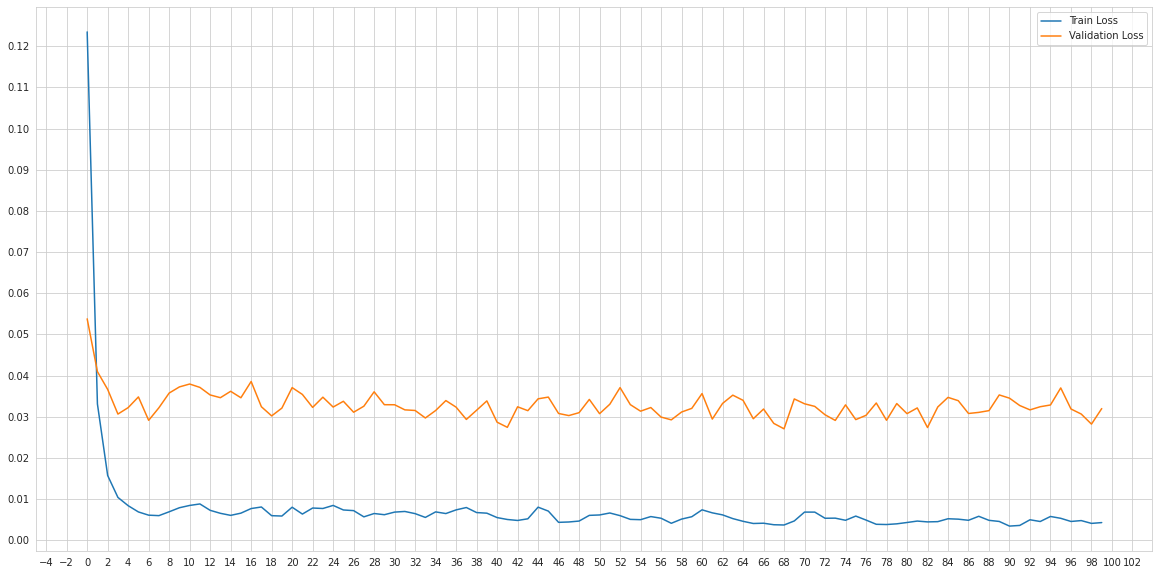

In [12]:
# best performing two-hidden-layer MLP had the following parameters

model_number = '1'
args = Namespace(
    # Data and path information
    movie_csv=path_to_clean_train_csv,
    save_dir=model_save_directory,
    model_number=model_number,
    dataset_file='{}/{}/dataset.pkl'.format(model_save_directory, model_number),
    vectroizer_file='{}/{}/vectroizer.pkl'.format(model_save_directory, model_number),
    label_indexer_file='{}/{}/label_indexer.pkl'.format(model_save_directory, model_number),
    model_state_file='{}/{}/model.pth'.format(model_save_directory, model_number),
    train_state_file='{}/{}/train_state.pkl'.format(model_save_directory, model_number),
    submission_path = '{}/{}/submission.csv'.format(model_save_directory, model_number),
    tfidf=False,
    # Training hyperparameters
    hidden_size1=512,
    use_hidden2=True,
    hidden_size2=128,
    batch_size=16,
    use_dropout=True,
    dropout_p1=0.3,
    dropout_p2=0.2,
    use_batch_norm=True,
    learning_rate=0.001,
    num_epochs=100
)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")


# training state
def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_all_true_labels': [],
            'train_all_pred_labels': [],
            'train_classification_report': [],
            'val_loss': [],
            'val_all_true_labels': [],
            'val_all_pred_labels': [],
            'val_classification_report': [],
            'test_loss': [],
            'test_classification_report': []}
train_state = make_train_state(args)

# instantiate dataset and vectorizer

dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(args.movie_csv, tfidf=args.tfidf)
vectorizer = dataset.get_vectorizer()
label_indexer = dataset.get_label_indexer()

if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
if not os.path.exists(os.path.join(args.save_dir, args.model_number)):
    os.mkdir(os.path.join(args.save_dir, args.model_number))
with open(args.dataset_file, "wb") as output_file:
    pkl.dump(dataset, output_file)
with open(args.vectroizer_file, "wb") as output_file:
    pkl.dump(vectorizer, output_file)
with open(args.label_indexer_file, "wb") as output_file:
    pkl.dump(label_indexer, output_file)

labels = [label_indexer.idx2label[_idx] for _idx in range(len(label_indexer))]

# model
classifier = MLPMultiLabelClassifier(input_size=len(vectorizer.text_vocab) if not args.tfidf else len(vectorizer.get_feature_names_out()), hidden_size1=args.hidden_size1, output_size=len(label_indexer), use_hidden2=args.use_hidden2, hidden_size2=args.hidden_size2, use_dropout=args.use_dropout, dropout_p1=args.dropout_p1, dropout_p2=args.dropout_p2, use_batch_norm=args.use_batch_norm)
classifier = classifier.to(args.device)

# instantiate loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=1e-4)

for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    # generate batches and iterate over training dataset
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0

    batch_wise_true_labels = []
    batch_wise_predictions = []

    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):

        # 1: zero gradients
        optimizer.zero_grad()

        # 2: get model predictions
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # 3: get loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # 4: get gradients
        loss.backward()

        # optional: clip the grad norm
        nn.utils.clip_grad_norm_(classifier.parameters(), 3.0)

        # step 5. use optimizer to take gradient step
        optimizer.step()

        # metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())

    train_state['train_loss'].append(running_loss)
    
    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_pred_labels = list(chain.from_iterable(batch_wise_predictions))
    train_state['train_all_true_labels'].append(all_true_labels)
    train_state['train_all_pred_labels'].append(all_pred_labels)

    # generate a classification report
    print("Train classification report after epoch: {}".format(train_state['epoch_index']))
    train_classification_report = classification_report(all_true_labels, all_pred_labels, target_names=labels, output_dict=True)
    train_state['train_classification_report'].append(train_classification_report)
    print(classification_report(all_true_labels, all_pred_labels, target_names=labels))

    # generate batches and iterate over validation dataset
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.

    classifier.eval()

    batch_wise_true_labels = []
    batch_wise_predictions = []

    for batch_index, batch_dict in enumerate(batch_generator):

        # 1: get model predictions
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())

    train_state['val_loss'].append(running_loss)
    
    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_pred_labels = list(chain.from_iterable(batch_wise_predictions))
    train_state['val_all_true_labels'].append(all_true_labels)
    train_state['val_all_pred_labels'].append(all_pred_labels)

    # generate a classification report
    print("Val classification report after epoch: {}".format(train_state['epoch_index']))
    val_classification_report = classification_report(all_true_labels, all_pred_labels, target_names=labels, output_dict=True)
    train_state['val_classification_report'].append(val_classification_report)
    print(classification_report(all_true_labels, all_pred_labels, target_names=labels))

# save model state dict
classifier_state_dict = classifier.state_dict()
torch.save(classifier_state_dict, args.model_state_file)

# save train state
with open(args.train_state_file, "wb") as output_file:
  pkl.dump(train_state, output_file)

# plot training and validation loss curves
all_train_running_losses = list(chain(train_state['train_loss']))
all_valid_running_losses = list(chain(train_state['val_loss']))

all_train_f1 = [_x['weighted avg']['f1-score'] for _x in train_state['train_classification_report']]
all_val_f1 = [_x['weighted avg']['f1-score'] for _x in train_state['val_classification_report']]

train_epoch_idx = range(len(train_state['train_loss']))
valid_epoch_idx = range(len(train_state['val_loss']))

plt.rcParams["figure.figsize"] = (20, 10)
sns.set_style('whitegrid')
locx = plticker.MultipleLocator(base=2.0)
locy = plticker.MultipleLocator(base=0.01)
axes = sns.lineplot(train_epoch_idx, all_train_running_losses, legend='brief', label='Train Loss')
axes.xaxis.set_major_locator(locx)
axes.yaxis.set_major_locator(locy)
sns.lineplot(valid_epoch_idx, all_valid_running_losses, legend='brief', label='Validation Loss')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


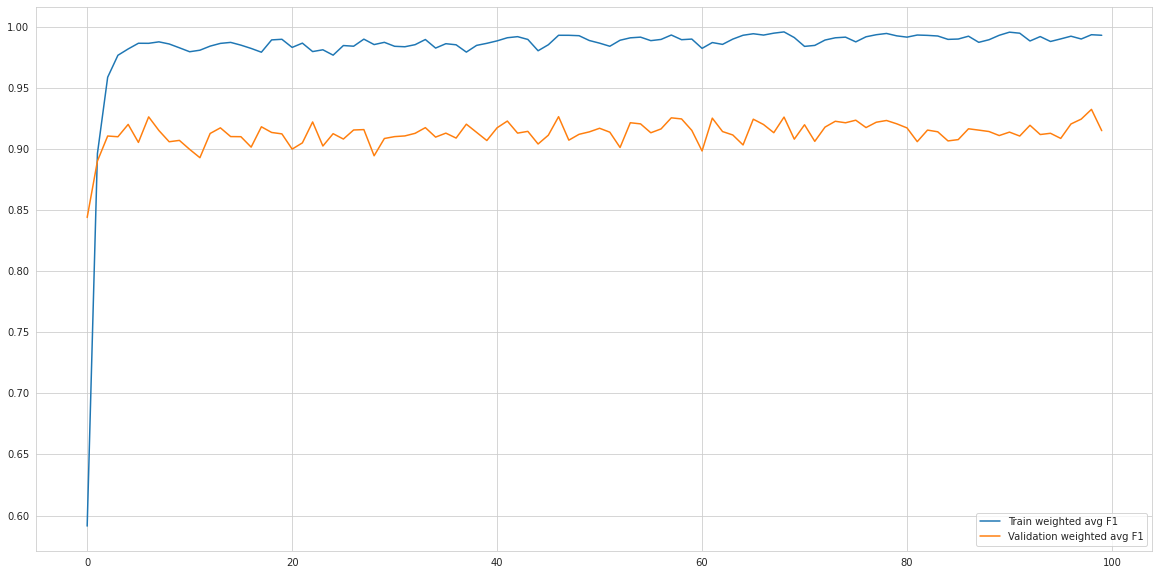

In [13]:
# plot for training and validation F1

all_train_f1 = [_x['weighted avg']['f1-score'] for _x in train_state['train_classification_report']]
all_val_f1 = [_x['weighted avg']['f1-score'] for _x in train_state['val_classification_report']]
sns.lineplot(train_epoch_idx, all_train_f1, legend='brief', label='Train weighted avg F1')

sns.lineplot(valid_epoch_idx, all_val_f1, legend='brief', label='Validation weighted avg F1')
plt.show()

In [15]:
# predict labels for test set
def predict_labels(text, classifier, vectorizer, label_indexer,
                   threshold=0.5, tfidf=False):
    """Predict the labels for the movie text

    Args:
        text: the text of the movie
        classifier: the trained model
        vectorizer: the corresponding vectorizer
        threshold: the threshold for positive and negative
    """

    processed_text = preprocess_text(text)
    if tfidf:
      vectorized_text = torch.FloatTensor(vectorizer.transform([processed_text]).todense()).squeeze(0)
      y_pred = classifier(vectorized_text)
    else:
      vectorized_text = torch.tensor(vectorizer.vectorize(processed_text))
      # made a mistake of using squeeze in the models so the model doesnt work for a batch size of 1, hence have to pass two texts, so 
      reshaped_vectorized_text = torch.reshape(vectorized_text, (1, vectorized_text.shape[0]))
      y_pred = classifier(torch.cat((reshaped_vectorized_text, reshaped_vectorized_text), dim=0).squeeze())[0]
    y_pred_normalized = F.sigmoid(y_pred)
    y_pred_labels = y_pred_normalized >= threshold
    labels = [label_indexer.idx2label[_idx] for _idx, value in enumerate(y_pred_labels.tolist()) if value]
    return labels


test_movies_df = pd.read_csv(path_to_test_movies_csv)
test_movies_df.columns = ["id", "text"]
all_text_labels = []
all_text_ids = []
for _idx, _text in enumerate(test_movies_df.text, 0):
    labels = predict_labels(text=_text, classifier=classifier, vectorizer=vectorizer, label_indexer=label_indexer, threshold=0.5)
    labels = ["" if _label == 'none' else _label for _label in labels]
    formatted_labels = " ".join(labels).strip()
    all_text_ids.append(_idx)
    all_text_labels.append(formatted_labels)
    print(_idx)
    print("text: {}".format(_text))
    print("labels: {}".format(formatted_labels))

submission_columns = ["ID", "CORE RELATIONS"]
submission_df = pd.DataFrame(columns=submission_columns, data={"ID": all_text_ids, "CORE RELATIONS": all_text_labels})
print(submission_df)
submission_df.to_csv(args.submission_path, index=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0
text: star of thor
labels: movie.starring.actor
1
text: who is in the movie the campaign
labels: movie.starring.actor
2
text: list the cast of the movie the campaign
labels: movie.starring.actor
3
text: who was in twilight
labels: movie.starring.actor
4
text: who is in vulguria
labels: movie.starring.actor
5
text: actor from lost
labels: movie.starring.actor
6
text: who played in the movie rocky
labels: movie.starring.actor
7
text: who played in the movie captain america
labels: movie.starring.actor
8
text: cast and crew for in july
labels: movie.starring.actor
9
text: who is in movie in july
labels: movie.starring.actor
10
text: who's in star wars episode four
labels: movie.starring.actor
11
text: who was in apollo thirteen
labels: movie.starring.actor
12
text: who was apollo thirteen 's cast
labels: movie.starring.actor
13
text: search for information about the cast and crew of appolo thirteen
labels: movie.starring.actor
14
text: i would like to know more about the cast and crew o